In [2]:
import pandas as pd
import numpy as np
import torch
import os
import torch.nn as nn                  
import torch.nn.functional as F       
import torch.optim as optim            
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics.functional as metrics 
import string

## 피드백
- 나라별 알파벳 빈도수 그래프로 확인하기  =>  추가 완료
- 빈도수로는 잘 했음

In [3]:
# 데이터 로드 함수
def loading_data(t):
    folder_path = f'../../data/lang/{t}'
    csv_file_path = f"../../data/lang/{t}.csv"

    with open(csv_file_path, "w", encoding="utf-8", newline='') as csv_f:
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                if file.startswith('en'):
                    label = 0
                elif file.startswith('fr'):
                    label = 1
                elif file.startswith('id'):
                    label = 2
                elif file.startswith('tl'):
                    label = 3
                csv_f.write(str(label) + ",")

                # 알파벳 dict 생성
                data = {}
                for char in string.ascii_uppercase:
                    data[char] = 0

                while True:
                    char = f.read(1)
                    if not char:
                        break
                    if char in string.ascii_letters:
                        char = char.upper()
                        data[char] += 1
                csv_f.write(','.join(map(str, data.values())) + "\r\n")

In [4]:
loading_data('train')

In [5]:
loading_data('test')

In [6]:
trainDF = pd.read_csv('../../data/lang/train.csv',header=None)
testDF = pd.read_csv('../../data/lang/test.csv',header=None)

In [7]:
trainDF  # 0번째 컬럼은 라벨, 알파벳 횟수는 A~Z 순서대로

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0,349,59,210,212,484,72,88,201,340,...,0,357,282,370,119,45,65,3,92,2
1,0,1856,238,856,638,2030,408,306,756,1574,...,34,1254,1324,1689,536,158,286,41,302,107
2,0,706,167,255,326,1149,146,262,230,632,...,46,756,601,652,257,115,117,17,90,5
3,0,259,44,165,118,434,53,91,85,342,...,6,195,318,293,105,68,43,2,65,2
4,0,383,147,159,210,642,89,125,313,346,...,2,314,389,497,129,27,104,32,93,9
5,0,337,93,142,181,645,93,93,260,297,...,2,331,272,436,114,49,109,14,68,3
6,0,998,167,441,419,1524,235,234,455,929,...,13,952,870,1087,299,276,164,28,190,10
7,0,2639,531,1369,1275,3863,734,615,1185,2376,...,16,2256,2091,2456,892,403,441,62,525,45
8,0,3977,700,1321,1834,5180,924,689,2141,3567,...,26,2526,3219,3598,1428,391,740,111,659,19
9,0,5662,906,2252,2611,8499,1518,1155,3509,5294,...,116,4425,4934,5785,2504,811,1157,81,946,79


In [8]:
feature = trainDF[trainDF.columns[1:]]
feature.columns = [i for i in string.ascii_uppercase]
feature

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
0,349,59,210,212,484,72,88,201,340,8,...,0,357,282,370,119,45,65,3,92,2
1,1856,238,856,638,2030,408,306,756,1574,20,...,34,1254,1324,1689,536,158,286,41,302,107
2,706,167,255,326,1149,146,262,230,632,22,...,46,756,601,652,257,115,117,17,90,5
3,259,44,165,118,434,53,91,85,342,9,...,6,195,318,293,105,68,43,2,65,2
4,383,147,159,210,642,89,125,313,346,8,...,2,314,389,497,129,27,104,32,93,9
5,337,93,142,181,645,93,93,260,297,15,...,2,331,272,436,114,49,109,14,68,3
6,998,167,441,419,1524,235,234,455,929,10,...,13,952,870,1087,299,276,164,28,190,10
7,2639,531,1369,1275,3863,734,615,1185,2376,34,...,16,2256,2091,2456,892,403,441,62,525,45
8,3977,700,1321,1834,5180,924,689,2141,3567,96,...,26,2526,3219,3598,1428,391,740,111,659,19
9,5662,906,2252,2611,8499,1518,1155,3509,5294,144,...,116,4425,4934,5785,2504,811,1157,81,946,79


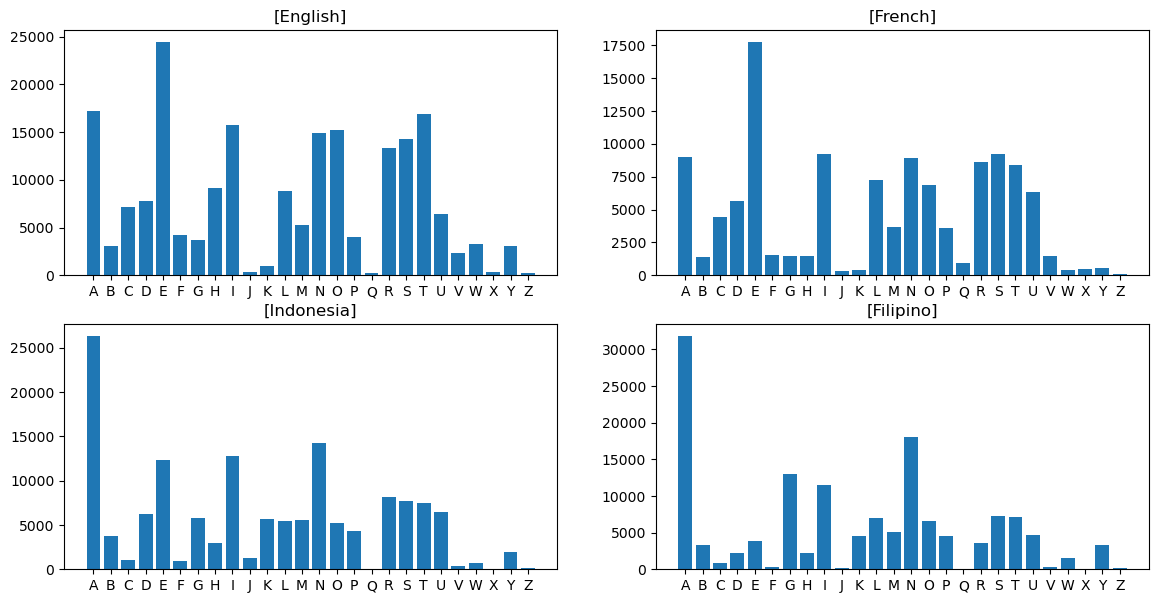

In [9]:
# 언어별 알파벳 빈도수 시각화 해보기
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
plt.bar(feature.columns, feature.iloc[:10].sum())
plt.title('[English]')
plt.subplot(2,2,2)
plt.bar(feature.columns, feature.iloc[10:20].sum())
plt.title('[French]')
plt.subplot(2,2,3)
plt.bar(feature.columns, feature.iloc[20:30].sum())
plt.title('[Indonesia]')
plt.subplot(2,2,4)
plt.bar(feature.columns, feature.iloc[30:40].sum())
plt.title('[Filipino]')
plt.show()

In [10]:
train_label = trainDF.iloc[:,0]
train_data = trainDF.iloc[:,1:]
test_label = testDF.iloc[:,0]
test_data = testDF.iloc[:,1:]

In [11]:
class DLdataset(Dataset):
    
    def __init__(self,x_data,y_data):
        super().__init__()
        x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data
        y_data = y_data.values if isinstance(y_data, pd.DataFrame) else y_data
        
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data)
        
    def __len__(self):
        return self.target.shape[0]
    
    def __getitem__(self,idx):
        return self.feature[idx], self.target[idx]
    

In [12]:
# 데이터셋 생성
train_dataset = DLdataset(train_data,train_label)
test_dataset = DLdataset(test_data,test_label)

In [13]:
trainDS, validDS = random_split(train_dataset, [0.8,0.2], generator=torch.Generator().manual_seed(42))

In [14]:
trainDL = DataLoader(trainDS, batch_size=32)
validDL = DataLoader(validDS, batch_size=32)

In [15]:
class Model(nn.Module):
    
    def __init__(self, IN, OUT):
        super().__init__()
        self.input = nn.Linear(IN, 128) 
        self.af = nn.LeakyReLU()
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 8)
        self.output = nn.Linear(8, OUT)
        
    def forward(self, x):
        y = self.input(x)
        y = self.af(y)
        y = self.hidden1(y)
        y = self.af(y)
        y = self.hidden2(y)
        y = self.af(y)
        y = self.hidden3(y)
        y = self.af(y)
        y = self.output(y)
        
        return y

In [16]:
train_dataset.feature.shape

torch.Size([40, 26])

In [17]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 100

IN = train_dataset.feature.shape[1]
OUT = pd.Series(train_label).nunique()

LF = nn.CrossEntropyLoss().to(DEVICE)

model = Model(IN, OUT)

OPTIMIZER = torch.optim.Adam(model.parameters())

scheduler = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 3)

In [18]:
def training(dl):
    
    model.train()
    train_report=[[], []]
    for (feature, target) in dl:

        feature, target = feature.to(DEVICE), target.to(DEVICE)
        
        # 학습
        pre_target = model(feature)
        
        # 손실계산
        loss = LF(pre_target, target)
        train_report[0].append(loss.item())
  
        # 성능 평가
        recall = metrics.recall(pre_target.argmax(dim=1), target, task = 'multiclass',num_classes=OUT)
        train_report[1].append(recall.item())
        # W,b업데이트
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
    loss_score = sum(train_report[0])/len(train_report[0])
    re_score = sum(train_report[1])/len(train_report[1])
    print(f'[Train loss] ==> {loss_score}    [Train Recall] ==> {re_score}')
    return loss_score, re_score

In [19]:
def testing(dl):
    model.eval()
    
    with torch.no_grad():
        val_report=[[], []]
        for (feature, target)  in dl:
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            
            pre_target = model(feature)
            
            loss = LF(pre_target, target)
            val_report[0].append(loss.item())
      

            recall = metrics.recall(pre_target.argmax(dim=1), target, task = 'multiclass',num_classes=OUT)
            val_report[1].append(recall.item())
    
        loss_score = sum(val_report[0])/len(val_report[0])
        re_score = sum(val_report[1])/len(val_report[1])

    print(f'[Test loss] ==> {loss_score}    [Test Recall] ==> {re_score}')
    return loss_score, re_score

In [20]:
train_report = [[],[]]
val_report = [[],[]]
filepath = '../../Web/model/language_model.pt'

min_loss = 10
for eps in range(EPOCHS):
    print(f'[{eps+1}/{EPOCHS}]')
    
    losst, ret = training(trainDL)
    lossv, rev = testing(validDL)
    
    train_report[0].append(losst)
    train_report[1].append(ret)
    val_report[0].append(lossv)
    val_report[1].append(rev)
    
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"Epoch {eps}번에서 조기종료")
        break
    if lossv < min_loss:
        min_loss = lossv
        torch.save(model, filepath)

[1/100]
[Train loss] ==> 31.278343200683594    [Train Recall] ==> 0.25
[Test loss] ==> 21.695039749145508    [Test Recall] ==> 0.25
[2/100]
[Train loss] ==> 17.320234298706055    [Train Recall] ==> 0.25
[Test loss] ==> 10.59813117980957    [Test Recall] ==> 0.25
[3/100]
[Train loss] ==> 8.23639965057373    [Train Recall] ==> 0.15625
[Test loss] ==> 2.5721113681793213    [Test Recall] ==> 0.25
[4/100]
[Train loss] ==> 2.487362861633301    [Train Recall] ==> 0.15625
[Test loss] ==> 1.3680458068847656    [Test Recall] ==> 0.375
[5/100]
[Train loss] ==> 1.748326063156128    [Train Recall] ==> 0.21875
[Test loss] ==> 1.1915385723114014    [Test Recall] ==> 0.375
[6/100]
[Train loss] ==> 1.3792661428451538    [Train Recall] ==> 0.21875
[Test loss] ==> 1.2388824224472046    [Test Recall] ==> 0.375
[7/100]
[Train loss] ==> 1.396836757659912    [Train Recall] ==> 0.21875
[Test loss] ==> 1.1662315130233765    [Test Recall] ==> 0.375
[8/100]
[Train loss] ==> 1.3128281831741333    [Train Recall] =

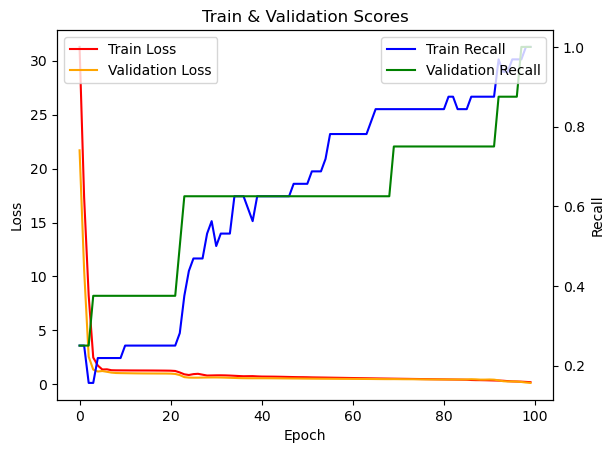

In [21]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()  


ax1.plot(train_report[0], label='Train Loss', color='red')
ax1.plot(val_report[0], label='Validation Loss', color='orange')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(train_report[1], label='Train Recall', color='blue')
ax2.plot(val_report[1], label='Validation Recall', color='green')
ax2.set_ylabel('Recall')
ax2.set_xlabel('Epoch')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.xlabel('Epoch')  
plt.title('Train & Validation Scores')
plt.show()

In [22]:
# 예측 함수
def predict(dl):
    model.eval()
    with torch.no_grad():
        pre = model(dl)
    recall = metrics.recall(pre, torch.tensor(test_label), task = 'multiclass',num_classes=OUT)
    acc = metrics.accuracy(pre,torch.tensor(test_label), task = 'multiclass', num_classes=OUT)
    print(f'재현율 : {recall}')
    print(f'정확도 : {acc}')

In [23]:
testDS = torch.tensor(test_data.values, dtype=torch.float)

In [24]:
predict(testDS)

재현율 : 0.875
정확도 : 0.875


In [25]:
# 예측 함수
def predict_one(model, filename):

    with open(filename, 'r', encoding='utf-8') as f:

        test_data = {}
        for char in string.ascii_uppercase:
            test_data[char] = 0
            
        while True:
            char = f.read(1)
            if not char:
                break
            if char in string.ascii_letters:
                char = char.upper()
                test_data[char] += 1
                
    test_data = torch.tensor(pd.Series(test_data), dtype=torch.float)
    
    with torch.no_grad():
        pre = model(test_data)
    pre = torch.argmax(pre).item()
    if pre == 0:
        print('예측 : English / 영어')
    elif pre == 1:
        print('예측 : French / 불어')
    elif pre == 2:
        print('예측 : Indonesia / 인도네시아어')
    elif pre == 3:
        print('예측 : Filipino / 필리핀어')

In [26]:
# 해당 언어 아무데서 긁어와서 text파일로 만듦 -> predict
predict_one(model,'../data/lang/fr.txt')
predict_one(model, '../data/lang/id.txt')

FileNotFoundError: [Errno 2] No such file or directory: '../data/lang/fr.txt'